# **Experimenting with a Quadratic Physics-Informed Neural Network (PINN)**

This notebook contains the code to create a PINN using PyTorch that can fit synthetic data with Gaussian noise around a quadratic function.

<br>

Essentially a PINN is a model that uses prior information inside the cost function to make the data more effective on sparse datasets and allows the model to understand deeper trends within the data to fit the ground-truth line outside of the training points as well.


## **Problem Setup**

We will create a PINN to fit synthetic data with Gaussian noise arund the line.

$$ y = ax^2 + bx + c $$

In this instance the prior information in this PINN will look to minimize this basic differential equation.

$$ \frac{d^3n}{dx^3} $$

This equation applies our prior information that our data exhibits a quadratic relationship.



In this model we have manipulated the layers and neurons as well as tested out different regularization parameter ($\lambda$) values. To better understand the impact these changes can make to our PINN.

## **Workflow**



1.   Environment Setup


2.   Generate noisy data


3.   Set up Neural Network Class


4.   Set up training process


5.   Create and train a neural network


6.   Modify regularization parameter


7.   Calculate Mean Squared Error (MSE)


8.   Working with higher order regularization


9.   Modify number of layers and neurons




## **1. Environment Setup**

First we mount the notebook to Google Drive to store all the figures created

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

images_dir = '/content/drive/MyDrive/quadnn_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Second we create our PINN in PyTorch which requires Python. Once we have both programs downloaded we can import all the torch modules we need as well as NumPy and Matplotlib.

####**Uses for each program**


1.   PyTorch can store data in tensors and set up the neural network
2.   NumPy helps us convert tensors into arrays for plotting
3.   Matplotlib creates easy to understand plots



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split

## **2. Generate Noisy Data**

Using the equation

$$ y = ax^2 + bx + c + \epsilon $$

Where $\epsilon$ is the Gaussian noise; we generate data around the line $y = ax^2 + bx + c$.



We create $X$ and $Y$ tensors to store the data points in its respective tensor, and store our data using the `TensorDataset()` class which stores a list of tensors essentially making a 2D matrix of $X$ and $Y$ values

We also define a `ground_truth()` function which input an $x$ value into the function $f(x) = ax^2 + bx + c$ and returns the output.

In [ ]:
#create Gaussian noise with mean 0 and variance 0.01
n = 10
g_noise = torch.randn(n,1) * np.sqrt(0.01)

# no need to set require_grad when creating X,
# otherwise there is a computation graph from X to Y.
X = torch.linspace(0, 1, n).view(-1,1)
print(X)
a = 1
b = 1
c = 1

Y = a * (X**2) + b * X + c + g_noise
print(Y)

dataset = TensorDataset(X, Y)

def ground_truth(x):
  return a * (x**2) + b * x + c

tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]])
tensor([[1.0684],
        [1.0959],
        [1.3911],
        [1.4276],
        [1.5978],
        [1.7936],
        [2.2158],
        [2.3447],
        [2.7922],
        [3.1103]])


Here we plot the noisy data and the ground truth line on the interval $[-1, 2]$ and save this figure to a Google Drive folder.

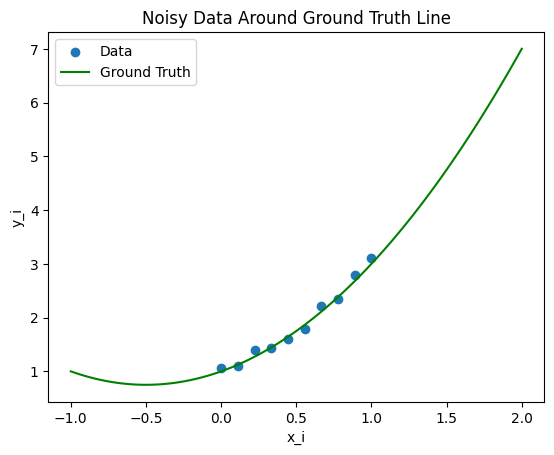

In [ ]:
#plot the data points + line w/out noise
x_plot = torch.linspace(-1, 2, 100).view(-1, 1)

plt.scatter(X.numpy(), Y.numpy(), label='Data')
plt.plot(x_plot.numpy(), ground_truth(x_plot).numpy(), color='green', label='Ground Truth')
plt.xlabel('x_i')
plt.ylabel('y_i')
plt.legend()
plt.title("Noisy Data Around Ground Truth Line")
plt.savefig(f"{images_dir}/noisy_data_truth.png")
plt.show()

Loads and prepares our dataset by dividing up the data based on the `batch_size` given and shuffling the data around to prevent the model from learning any order-dependent patterns.

In [ ]:
#setting up batches in DataLoader
batch_size = 10
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## **3. Set up Neural Network Class**

We set up a standard neural network where `d` and `w` represent the number of layers and neurons in the network respectively. Using the Tanh activation function we can introduce non-linearities to allow the model to understand deep trends in seemigly abstract data.

<br>

The `compute_first_derivative()` function computes the $1 - n$th derivative using PyTorch's autodifferentiation features.

<br>

Our `criterion` object signifies our Mean Squared Error (MSE) loss which lets us know how accurate our models predictions are when we are training.

Our `optimizer` object aims to minimize the loss using the Adaptive Motion Estimation (Adam).



In [ ]:
#creating the neural network
class Net(nn.Module):
    def __init__(self, d, w):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(1, w))

        for i in range(d-2):
          self.layers.append(nn.Linear(w, w))

        self.layers.append(nn.Linear(w, 1))


    def forward(self, x):
        for layer in self.layers[:-1]:
          x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        return x

    def compute_first_derivative(self, x_input):
      first_derivative = torch.autograd.grad(outputs=self(x_input), inputs=x_input,
                                               grad_outputs=torch.ones_like(self(x_input)),
                                               create_graph=True, retain_graph=True)[0]
      second_derivative = torch.autograd.grad(outputs=first_derivative, inputs=x_input,
                                              grad_outputs=torch.ones_like(first_derivative),
                                              create_graph=True, retain_graph=True)[0]

      third_derivative = torch.autograd.grad(outputs=second_derivative, inputs=x_input,
                                              grad_outputs=torch.ones_like(second_derivative),
                                              create_graph=True, retain_graph=True)[0]
      return first_derivative, second_derivative, third_derivative
d, w = 4, 15
model = Net(d, w)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

## **4. Set up training process**

Now that we have our network class we will train a model using our neural network.

<br>

Since we have created a PINN our regularization parameter ($\lambda$) cannot be assumed as zero. Therefore by using PyTorch's `autograd.grad()` function we can take the third derivative of the function (prior information) and ensure that the third derivative is as close to zero as possible.

<br>

Essentially regularization penalizes higher degree models in order to keep the model cohesive and follow analytical trends within certain boundaries.

In [ ]:
#training function
def train(model, criterion, optimizer, epochs, lamda_reg):
    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in dataloader:
          x.requires_grad = True
          optimizer.zero_grad()
          outputs = model(x)
          mse = criterion(outputs, y)

          first_derivative = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True, retain_graph=True)[0]
          second_derivative = torch.autograd.grad(first_derivative, x, grad_outputs=torch.ones_like(first_derivative), create_graph=True, retain_graph=True)[0]
          third_derivative = torch.autograd.grad(second_derivative, x, grad_outputs=torch.ones_like(second_derivative), create_graph=True, retain_graph=True)[0]

          reg_term = third_derivative.pow(2).mean()
          total_loss = mse + lamda_reg * reg_term

          total_loss.backward()
          optimizer.step()

          losses.append(total_loss.item())

        #if epoch % 100 == 0:
          #print(f"Epoch {epoch+1}, total: {total_loss.item()}, mse: {mse.item()}, reg: {reg_term.item()}")
    return losses


## **5. Create and Train our Neural Network**

Now that we have set up a training process we can set certain parameters and train our model.

Here we set a defined number of epochs to run our network for and set a regularization parameter. Finally we train our model and save it in a variable `losses`.

In [ ]:
epochs = 5000
reg = 1.0
losses = train(model, criterion, optimizer, epochs, reg)


Upon plotting the **Training Loss over Epochs** we see the function present represents exponential decay. The regularization we used in our model evidently worked to minimize the loss function using prior information.

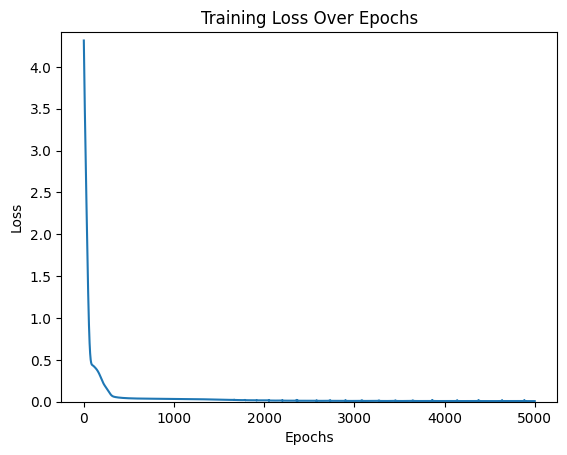

In [ ]:

plt.plot(np.arange(len(losses)), losses)
plt.ylim(0, max(losses)+0.1)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f"{images_dir}/loss_epochs.png")
plt.show()

To understand how well our Neural Network performs on the synthetic data we created we plotted Neural Network on top of our Ground Truth line and noisy data.

<br>

Here the network fits our training data very well and continues outside the training interval. However as the model moves further off the training interval it starts to stray from the ground truth.

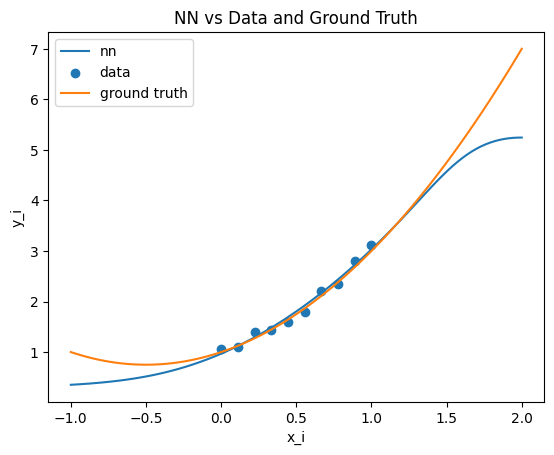

In [ ]:
#plot the data points + line w/out noise
#ask about how to improve for higher x values
x_network = torch.linspace(-1, 2, 100, requires_grad=True).view(-1, 1)
y_network = model(x_network)

plt.plot(x_network.detach().numpy(), y_network.detach().numpy(), label='nn')
plt.scatter(X.detach().numpy(), Y.detach().numpy(), label='data')
plt.plot(x_network.detach().numpy(), ground_truth(x_network).detach().numpy(), label='ground truth')
plt.xlabel('x_i')
plt.ylabel('y_i')
plt.legend()
plt.title('NN vs Data and Ground Truth')
plt.savefig(f"{images_dir}/nn_vs_data.png")
plt.show()

## **6. Modify Regularization Parameter**

To better understand how the regularization parameter ($\lambda$) effects our neural network we tested out different models with different $\lambda$ values.

<br>

We created multiple models with their respective $\lambda$ value and plotted them on the same axis to better understand the impact the $\lambda$ value makes.

In [ ]:
reg_terms = [1.0, 1e-6, 10.0]
x_plot = torch.linspace(-1, 2, 100, requires_grad=True).view(-1, 1)

# Initialize models and optimizers
models = [Net(d, w) for _ in range(len(reg_terms))]
optimizers = [optim.Adam(model.parameters()) for model in models]

In [ ]:
# Train each model with its corresponding regularization term
for i, reg_term in enumerate(reg_terms):
    train(models[i], criterion, optimizers[i], epochs, reg_term)

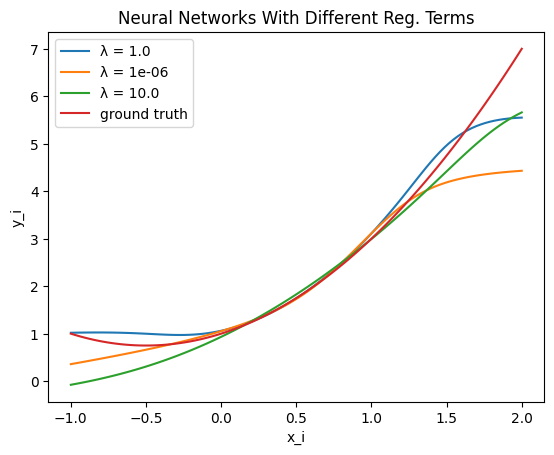

In [ ]:
#plot changes in reg term
for i, model in enumerate(models):
  plt.plot(x_plot.detach().numpy(), model(x_plot).detach().numpy(), label=f'λ = {reg_terms[i]}')
plt.plot(x_plot.detach().numpy(), ground_truth(x_plot).detach().numpy(), label='ground truth')

plt.xlabel('x_i')
plt.ylabel('y_i')
plt.legend()
plt.title('Neural Networks With Different Reg. Terms')
plt.savefig(f"{images_dir}/reg_changes.png")
plt.show()


Additionally we plotted the 1st, 2nd, and 3rd derivative of each model with different $\lambda$ values to understand how the influence of the regularization parameter changes with each model.

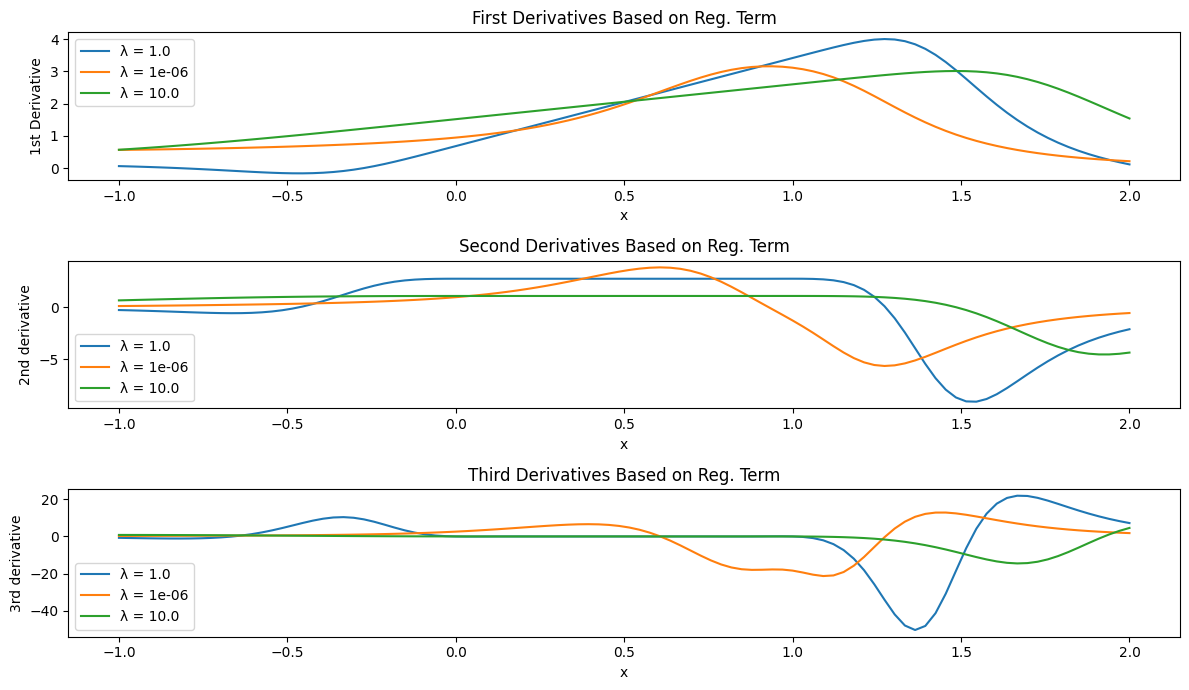

In [ ]:
plt.figure(figsize=(12, 7))

for i, model in enumerate(models):
    first_deriv, second_deriv, third_deriv = model.compute_first_derivative(x_plot)

    plt.subplot(3, 1, 1)
    plt.plot(x_plot.detach().numpy(), first_deriv.detach().numpy(), label=f'λ = {reg_terms[i]}')
    plt.legend()
    plt.title("First Derivatives Based on Reg. Term")
    plt.xlabel('x')
    plt.ylabel('1st Derivative')


    plt.subplot(3, 1, 2)
    plt.plot(x_plot.detach().numpy(), second_deriv.detach().numpy(), label=f'λ = {reg_terms[i]}')
    plt.legend()
    plt.title("Second Derivatives Based on Reg. Term")
    plt.xlabel('x')
    plt.ylabel('2nd derivative')

    plt.subplot(3, 1, 3)
    plt.plot(x_plot.detach().numpy(), third_deriv.detach().numpy(), label=f'λ = {reg_terms[i]}')
    plt.legend()
    plt.title("Third Derivatives Based on Reg. Term")
    plt.xlabel('x')
    plt.ylabel('3rd derivative')



plt.tight_layout()
plt.savefig(f"{images_dir}/reg_derivs.png")
plt.show()


## **7. Calculate Mean Squared Error (MSE)**

To evaluate our model we calculated the Mean Squared Error (MSE) of our network on different intervals using the `criterion()` function

<br>

First we calculated the MSE on the interval $[-1, 2]$ to understand the overall accuracy of our model beyond the training data.

<br>

Second we calculated the MSE on the interval $[0, 1]$ to understand the accurary of our model on the training data points.

<br>

Finally we calculated the MSE on the interval $[-1, 0] \: \cup \: [1, 2]$ to understand the accuracy of our model outside the training data points.

In [ ]:
#finding error
x_overall = torch.linspace(-1, 2, 300).view(-1, 1)
y_overall = model(x_overall)
y_ground_truth = ground_truth(x_overall)
mse_ground_truth = criterion(y_overall, y_ground_truth).item()
print('MSE for [-1, 2]: ', mse_ground_truth)
#mean squared error is MSE

#finding error inside interval [0, 1]
x_interval = torch.linspace(0, 1, 100).view(-1,1)
y_interval = ground_truth(x_interval)
y_interval_net = model(x_interval)
mse_interval = criterion(y_interval_net, y_interval).item()
print('MSE for [0, 1]: ', mse_interval)

#finding error outside interval [0, 1]
x_bound1 = torch.linspace(-1, 0, 100).view(-1,1)
x_bound2 = torch.linspace(1, 2, 100).view(-1,1)
x_bounds = torch.cat((x_bound1, x_bound2), 0)
y_bounds = ground_truth(x_bounds)
y_bounds_net = model(x_bounds)
mse_outside = criterion(y_bounds_net, y_bounds).item()
print('MSE for [-1, 0]∪[1, 2]: ', mse_outside)



MSE for [-1, 2]:  0.21990685164928436
MSE for [0, 1]:  0.0030593390110880136
MSE for [-1, 0]∪[1, 2]:  0.3261967599391937


## **8. Working with Higher Order Regularization**

We have explained the influence of the regularization parameter ($\lambda$) in our model before. Now we will implement a higher order regularization to minimize the 4th derivative of the loss function instead of the 3rd derivative.

<br>

What this does is penalize higher order models, however, this model doesn't penalize 3rd degree functions while our previous model did which can impact how well our network performs.

<br>

We also plot this new model on the ground truth to compare it to our previous model.

Epoch 1, total: 4.590548038482666, mse: 4.589435577392578, reg: 0.0011125693563371897
Epoch 101, total: 0.4122336506843567, mse: 0.39842963218688965, reg: 0.013804015703499317
Epoch 201, total: 0.3297002613544464, mse: 0.3254804313182831, reg: 0.004219832830131054
Epoch 301, total: 0.21248939633369446, mse: 0.2017330676317215, reg: 0.010756336152553558
Epoch 401, total: 0.10041166841983795, mse: 0.0949302688241005, reg: 0.005481400061398745
Epoch 501, total: 0.059066761285066605, mse: 0.05575773864984512, reg: 0.0033090219367295504
Epoch 601, total: 0.04065622016787529, mse: 0.03995320573449135, reg: 0.0007030147244222462
Epoch 701, total: 0.03788269683718681, mse: 0.03730447217822075, reg: 0.0005782232619822025
Epoch 801, total: 0.03618523105978966, mse: 0.03572513908147812, reg: 0.00046009087236598134
Epoch 901, total: 0.03463149815797806, mse: 0.034228794276714325, reg: 0.0004027044924441725
Epoch 1001, total: 0.03318805992603302, mse: 0.03282720968127251, reg: 0.000360850797733292


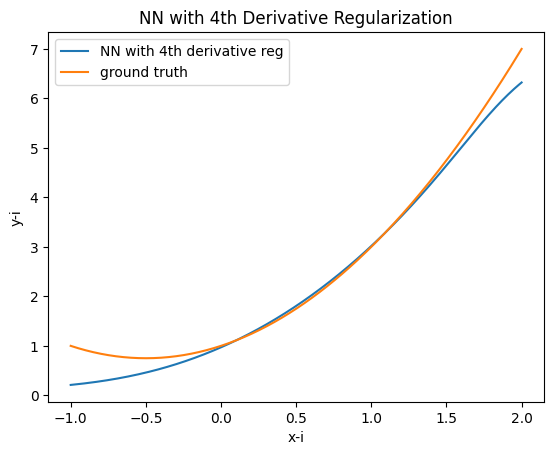

In [ ]:
# Using 4th derivative for regularization
def train_deriv4(model, criterion, optimizer, dataloader, epochs, lamda_reg):
    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in dataloader:
          x.requires_grad = True
          optimizer.zero_grad()
          outputs = model(x)
          mse = criterion(outputs, y)

          first_derivative = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
          second_derivative = torch.autograd.grad(first_derivative, x, grad_outputs=torch.ones_like(first_derivative), create_graph=True)[0]
          third_derivative = torch.autograd.grad(second_derivative, x, grad_outputs=torch.ones_like(second_derivative), create_graph=True)[0]
          fourth_derivative = torch.autograd.grad(third_derivative, x, grad_outputs=torch.ones_like(third_derivative), create_graph=True)[0]

          reg_term = fourth_derivative.pow(2).mean()
          total_loss = mse + lamda_reg * reg_term

          total_loss.backward()
          optimizer.step()

          losses.append(total_loss.item())

        if epoch % 100 == 0:
          print(f"Epoch {epoch+1}, total: {total_loss.item()}, mse: {mse.item()}, reg: {reg_term.item()}")
    return losses


model_deriv4 = Net(d, w)
optimizer = optim.Adam(model_deriv4.parameters())
train_deriv4(model_deriv4, criterion, optimizer, dataloader, epochs, 1)
y_net_deriv4 = model_deriv4(x_overall)
print('MSE over [-1, 2] for 3rd Deriv Reg:', criterion(y_net_deriv4, y_ground_truth).item())
plt.plot(x_overall.detach().numpy(), y_net_deriv4.detach().numpy(), label='NN with 4th derivative reg')
plt.plot(x_overall.detach().numpy(), ground_truth(x_overall).detach().numpy(), label='ground truth')
plt.xlabel('x-i')
plt.ylabel('y-i')
plt.legend()
plt.title('NN with 4th Derivative Regularization')
plt.savefig(f"{images_dir}/deriv4.png")
plt.show()
# what does this one being better tell us
#use this plot to lead into the quadratic ground truth function

## **9. Modify number of layers and neurons**

Finally to understand the impact of layers and neurons on our model we run different models with different layer, neuron configurations.

<br>

First we create a model with 1 layer and 1 neuron which isn't as good at understand abstract trends within data

<br>

Second we create a model with 3 layers and 5 neurons which can understand some trends, however, its capacity to understand deeper trends within data may be limited which affects its accuracy

<br>

Third we create a model with 4 layers and 15 neurons which was the setup that we used for our first model and this model captures the training data effectively as well as trends beyond the data.

<br>

Finally we plot each model against the ground truth line and evidently the model with 4 layers and 15 neurons performs better and fits the ground truth beyond the training data points as well!

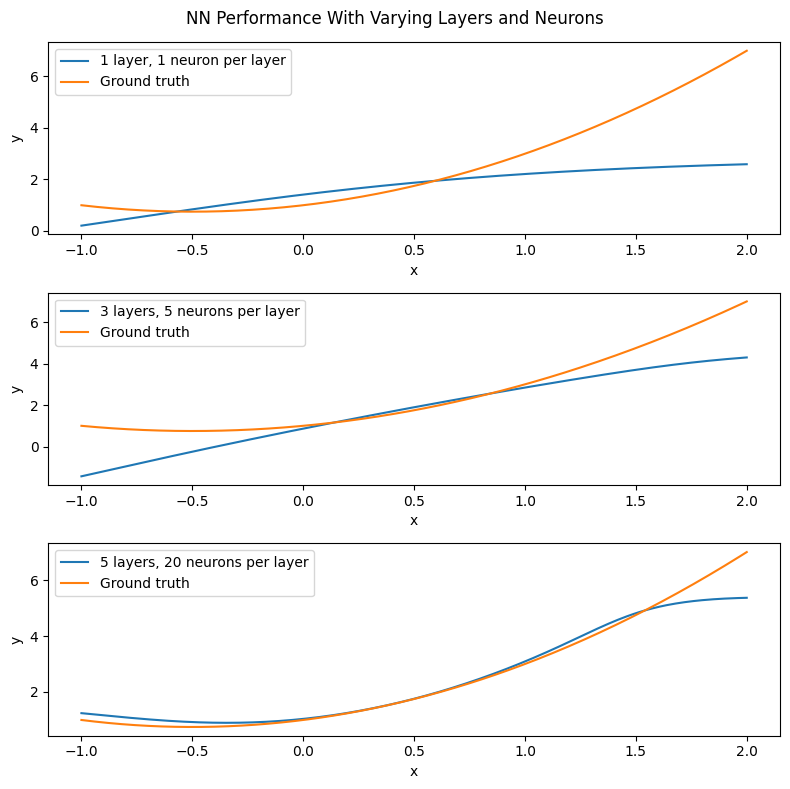

In [ ]:
model_test1 = Net(1, 1)
optimizer = optim.Adam(model_test1.parameters())
train(model_test1, criterion, optimizer, 5000, 1)

model_test2 = Net(3, 5)
optimizer = optim.Adam(model_test2.parameters())
train(model_test2, criterion, optimizer, 5000, 1)

model_test3 = Net(4, 15)
optimizer = optim.Adam(model_test3.parameters())
train(model_test3, criterion, optimizer, 5000, 1)

y_net_test1 = model_test1(x_overall)
y_net_test2 = model_test2(x_overall)
y_net_test3 = model_test3(x_overall)

y_net_tests = [y_net_test1, y_net_test2, y_net_test3]
ln = [[1, 1, ''], [3, 5, 's'], [5, 20, 's']]

plt.figure(figsize=(8, 8))

for i in range(len(y_net_tests)):
  plt.subplot(3, 1, i+1)
  plt.plot(x_overall.detach().numpy(), y_net_tests[i].detach().numpy(), label=f'{ln[i][0]} layer{ln[i][2]}, {ln[i][1]} neuron{ln[i][2]} per layer')
  plt.plot(x_overall.detach().numpy(), ground_truth(x_overall).detach().numpy(), label='Ground truth')
  plt.legend()
  plt.xlabel('x')
  plt.ylabel('y')

plt.suptitle('NN Performance With Varying Layers and Neurons')
plt.tight_layout()
plt.savefig(f"{images_dir}/layers_neurons.png")
plt.show()